# Sensitivities of various objective functions to iceshelf transfer coefficients 


In [1]:
import os
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from xmitgcm import open_mdsdataset
import MITgcmutils as mut

# My stuff
from pig_tools import diag_plot
import pig_tools as pt
import genMooringMasks as mm

In [2]:
shi_optim_dir = '/workspace/results/pig/shicoeff-sensitivities'
ver_dir = ('%s/shifwflx-3day' % shi_optim_dir)
grid_dir = ('%s/grid' % ver_dir)

ds = open_mdsdataset(data_dir=('%s/diags' % ver_dir),
                     grid_dir=('%s/grid'  % ver_dir),
                     geometry='sphericalpolar'
                    )
ctrl=open_mdsdataset(data_dir=ver_dir,
                     grid_dir=('%s/grid'  % ver_dir),
                     iters=0,
                     geometry='sphericalpolar'
                    )

/workspace/xmitgcm/xmitgcm/mds_store.py:812: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/shifwflx-3day. Using default version.
  "in %s. Using default version." % data_dir)


In [3]:
xc = ds.XC
yc = ds.YC
xg = ds.YG
yg = ds.YG
maskI = ds.maskCtrlI.isel(Z=0)

In [9]:
print(ds.dxC.mean().values)
print(ds.dyC.mean().values)

3605.1074
3603.17


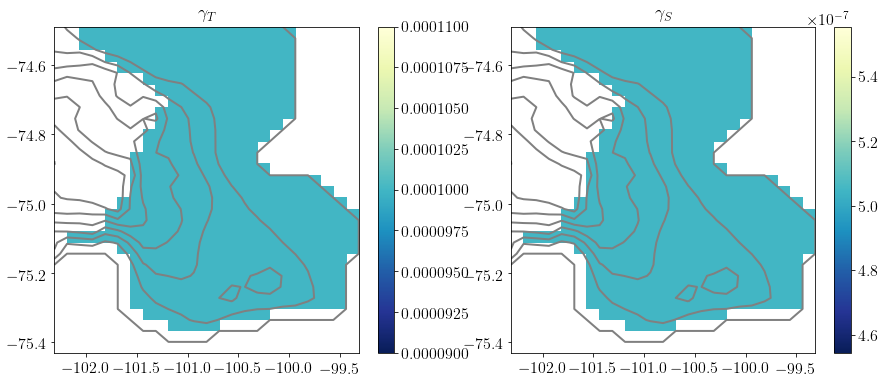

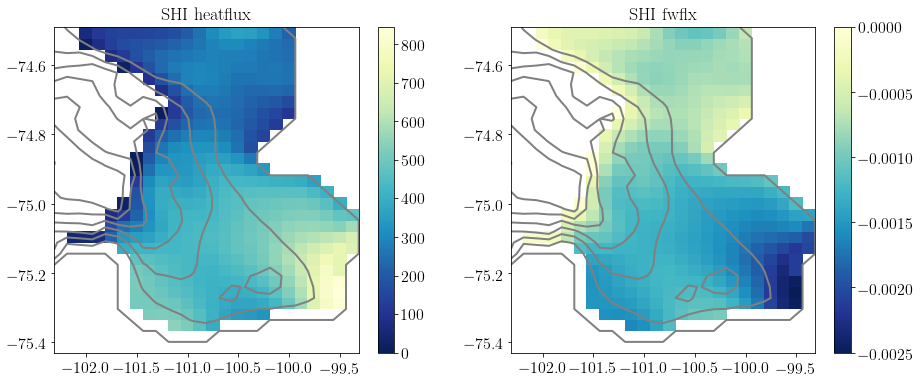

In [4]:
plt.rcParams['text.usetex']=True
diag_plot(xc,yc,ds.SHIgammT,ds.SHIgammS,title1='$\gamma_T$',title2='$\gamma_S$',
          depth=ds.Depth,mask1=maskI,mask2=maskI)
diag_plot(xc,yc,ds.SHIhtFlx,ds.SHIfwFlx,title1='SHI heatflux',title2='SHI fwflx',
          depth=ds.Depth,mask1=maskI,mask2=maskI)

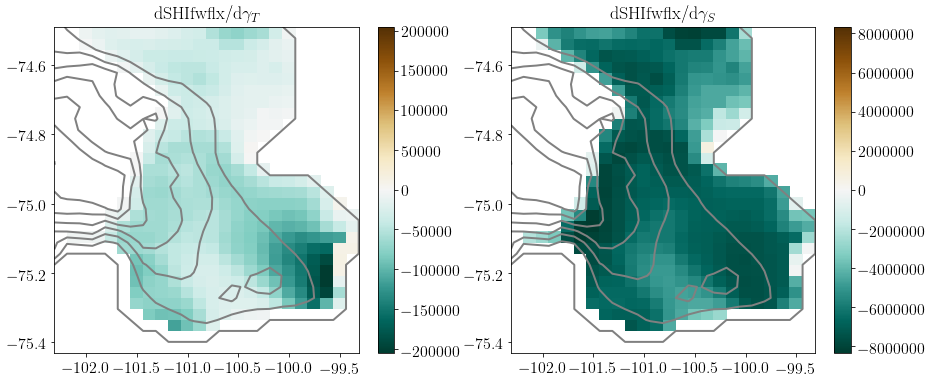

In [5]:
diag_plot(xc,yc,ctrl.adxx_shicoefft,ctrl.adxx_shicoeffs,
         title1='dSHIfwflx/d$\gamma_T$',title2='dSHIfwflx/d$\gamma_S$',depth=ds.Depth,
         mask1=maskI,mask2=maskI)

These sensitivities look like the patterns for $\gamma_T$ when $u^*$ is used, so hopefully we're ok. 

Consider:
- this is with iceshelf FWFLX as objective function, so would expect a broad sensitivity pattern here
- potentially all adjustments go to $\gamma_s$ if the two are not connected, need to consider this as an observable
- Need to think how T/S observations would perform

<img src='/workspace/gcm-contrib/pig/figures/parameter-sensitivity/useGammaFriction_log10gammaT.pdf'>

From Davis et al., (2018) citing Webber et al., (2017), 2 moorings at 
- Southern (iStar9): 75.059$^\circ$S 102.152$^\circ$W  
- Northern (iStar8): 74.863$^\circ$S 102.104$^\circ$W
which are iStar8 & iStar9 in Webber et al., (2017).

Collect measurements at roughly the depth levels **very rough, reading off a plot**:
- 380m
- 425m
- 480m
- 540m 
- 610m
- 700m

but need actual dataset to confirm. **Also, the Southern mooring was pushed downslope because of a large calving event between 2009-2013**

### Generate mask giving these two points in lat/lon at close enough depth levels

Using 8/9 to refer to moorings iStar8 (Northern) and iStar9 (Southern)

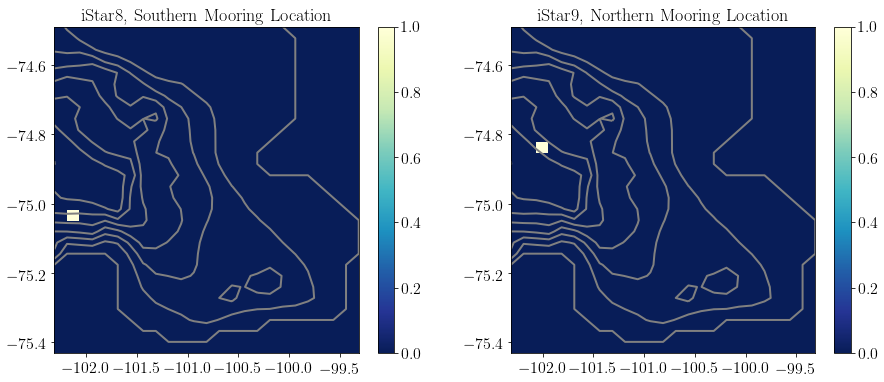

In [6]:
lat8 = -75.059
lon8 = -102.152
lat9 = -74.863
lon9 = -102.104
mooring_depth = np.array((-380,-425,-480,-540,-610,-700))
temporal_mask = np.array((1,0,0,0))
temporal_mask_string = 'np.array((1,0,0,0))'

iStar8 = mm.genMooringMask(ds,lat8,lon8,mooring_depth,mask_name='iStar8')
iStar9 = mm.genMooringMask(ds,lat9,lon9,mooring_depth,mask_name='iStar9')

diag_plot(xc,yc,iStar8.sel(Z=mooring_depth[0],method='nearest'),
                iStar9.sel(Z=mooring_depth[0],method='nearest'),
                title1='iStar8, Southern Mooring Location',
                title2='iStar9, Northern Mooring Location',
                depth=ds.Depth)

### Write out iStar8/9 mooring masks

In [7]:
msk_dir = 'istar_masks'
if not os.path.isdir(msk_dir):
    os.makedirs(msk_dir)
    
mm.writeMaskFile(iStar8.values,('%s/iStar8_3d_mskC' % msk_dir),
                 comments=iStar8.attrs['description']) 
mm.writeMaskFile(temporal_mask,('%s/iStar8_3d_mskT' % msk_dir),
                 comments=temporal_mask_string) 

mm.writeMaskFile(iStar9.values,('%s/iStar9_3d_mskC' % msk_dir), 
                 comments=iStar9.attrs['description']) 
mm.writeMaskFile(temporal_mask,('%s/iStar9_3d_mskT' % msk_dir),
                 comments=temporal_mask_string) 

istar_masks/iStar8_3d_mskC.meta/data files written ...
istar_masks/iStar8_3d_mskC binary file written ...
istar_masks/iStar8_3d_mskT.meta/data files written ...
istar_masks/iStar8_3d_mskT binary file written ...
istar_masks/iStar9_3d_mskC.meta/data files written ...
istar_masks/iStar9_3d_mskC binary file written ...
istar_masks/iStar9_3d_mskT.meta/data files written ...
istar_masks/iStar9_3d_mskT binary file written ...


(50, 30, 25)


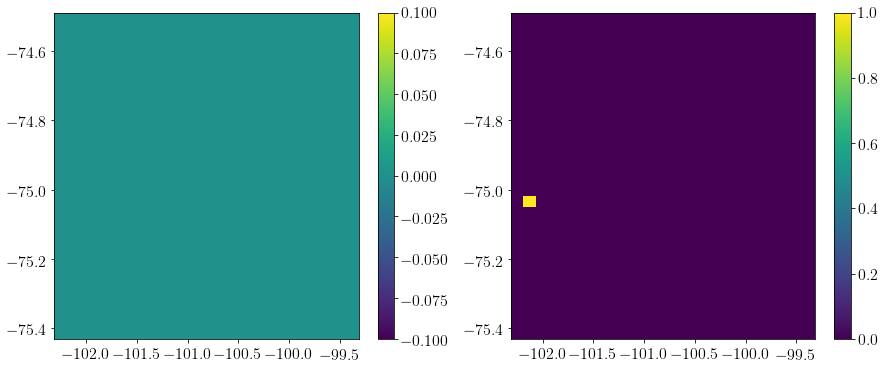

In [8]:
# Test that what's being written is as expected
testmsk = mut.rdmds(('%s/iStar8_3d_mskC' % msk_dir))
print(np.shape(testmsk))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.pcolormesh(xc,yc,testmsk[0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(xc,yc,testmsk[30,:,:])
plt.colorbar()
plt.show()

**Ok good to go ...**
### Now consider sensitivities to temperature at iStar locations

In [9]:
dsi = open_mdsdataset(data_dir=('%s/istar-t-3day' % shi_optim_dir),
                      grid_dir=('%s/grid' % ver_dir),
                      geometry='sphericalpolar',
                      iters=0
                     )

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/istar-t-3day. Using default version.
  "in %s. Using default version." % data_dir)
/workspace/xmitgcm/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/workspace/xmitgcm/xmitgcm/mds_store.py:269: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


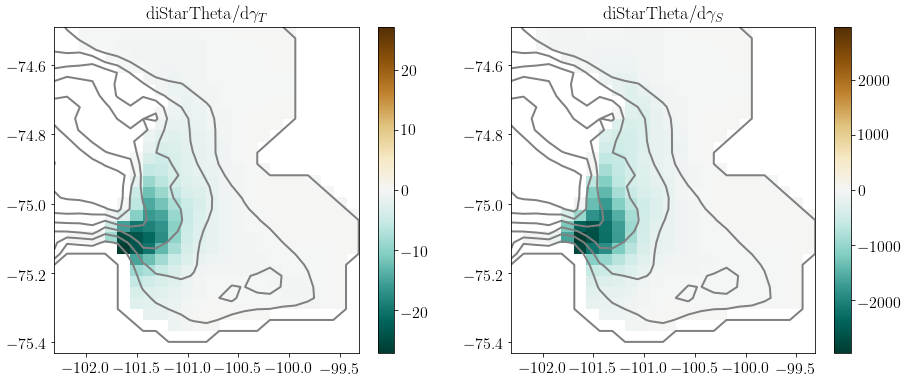

In [10]:
diag_plot(xc,yc,dsi.adxx_shicoefft,dsi.adxx_shicoeffs,
         title1='diStarTheta/d$\gamma_T$',title2='diStarTheta/d$\gamma_S$',depth=ds.Depth,
         mask1=maskI,mask2=maskI)

### Compare to sensitivities after a ten year spinup

In [11]:
dsis = open_mdsdataset(data_dir=('%s/istar-t-spunup-3day' % shi_optim_dir),
                      grid_dir=('%s/grid' % ver_dir),
                      geometry='sphericalpolar',
                      iters=0
                     )

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/istar-t-spunup-3day. Using default version.
  "in %s. Using default version." % data_dir)


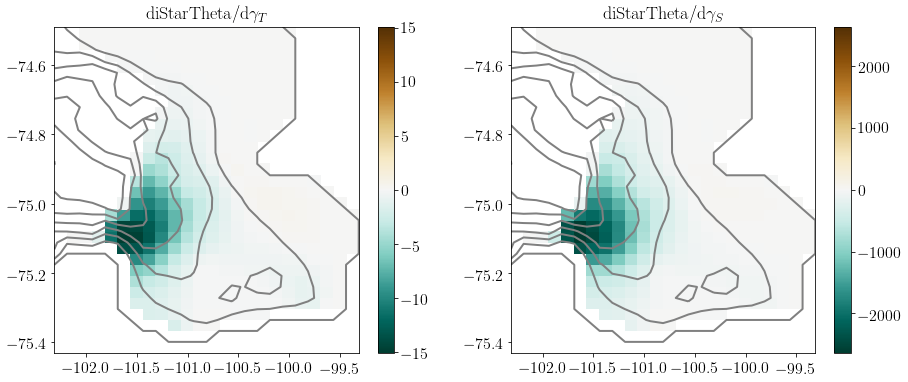

In [12]:
diag_plot(xc,yc,dsis.adxx_shicoefft,dsis.adxx_shicoeffs,
         title1='diStarTheta/d$\gamma_T$',title2='diStarTheta/d$\gamma_S$',depth=ds.Depth,
         mask1=maskI,mask2=maskI)

**The magnitude changed slightly, and the pattern is slightly broader, but sensitivities largely unaffected by having reached steady state** 

**Now lets look at the impact of observing salt in addition to temperature**

In [13]:
dsiss = open_mdsdataset(data_dir=('%s/istar-ts-spunup-3day' % shi_optim_dir),
                      grid_dir=('%s/grid' % ver_dir),
                      geometry='sphericalpolar',
                      iters=0
                     )

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/istar-ts-spunup-3day. Using default version.
  "in %s. Using default version." % data_dir)


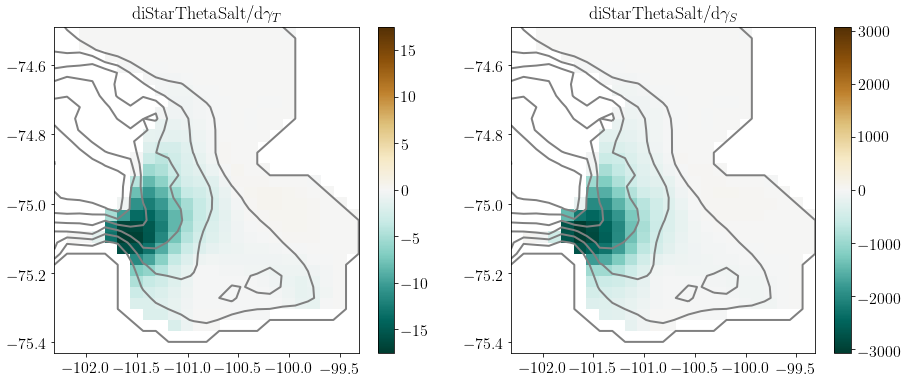

In [14]:
diag_plot(xc,yc,dsiss.adxx_shicoefft,dsiss.adxx_shicoeffs,
         title1='diStarThetaSalt/d$\gamma_T$',title2='diStarThetaSalt/d$\gamma_S$',depth=ds.Depth,
         mask1=maskI,mask2=maskI)

### And lets look at just salinity observations

In [15]:
dss = open_mdsdataset(data_dir=('%s/istar-s-spunup-3day' % shi_optim_dir),
                      grid_dir=('%s/grid' % ver_dir),
                      iters=0
                     )

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/istar-s-spunup-3day. Using default version.
  "in %s. Using default version." % data_dir)


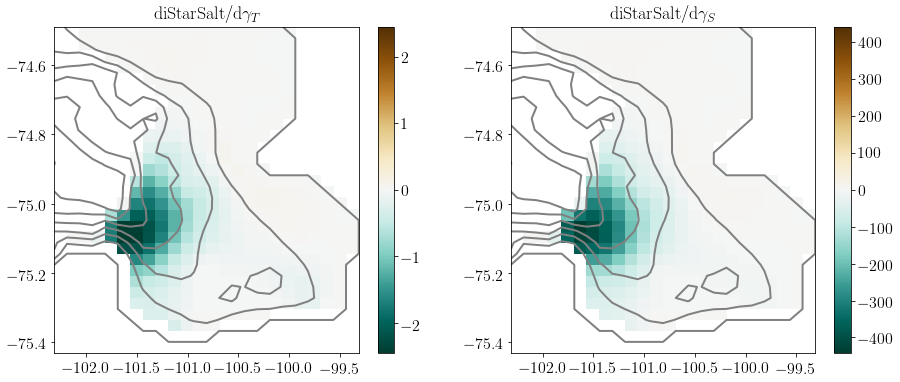

In [16]:
diag_plot(xc,yc,dss.adxx_shicoefft,dss.adxx_shicoeffs,
         title1='diStarSalt/d$\gamma_T$',title2='diStarSalt/d$\gamma_S$',depth=ds.Depth,
         mask1=maskI,mask2=maskI)

**Sensitivities are much smaller, indicating temperature observations potentially more impactful?**
Not necessarily, need to consider that relative changes in salinity are much smaller than temperature.
Same change in parameters leads to larger change in temperature than salinity, but which matters more for the quantity of interest? what is the QoI?

### 1 month objective function ...

In [17]:
ds_1mo = open_mdsdataset(data_dir=('%s/istar-ts-1mo' % shi_optim_dir),
                         grid_dir=('%s/grid' % ver_dir),
                         iters=0
                        )

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/istar-ts-1mo. Using default version.
  "in %s. Using default version." % data_dir)


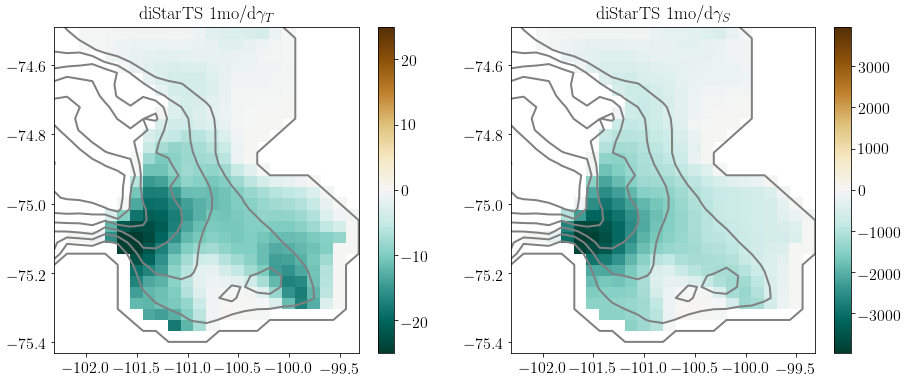

In [18]:
diag_plot(xc,yc,ds_1mo.adxx_shicoefft,ds_1mo.adxx_shicoeffs,
          title1='diStarTS 1mo/d$\gamma_T$',title2='diStarTS 1mo/d$\gamma_S$',depth=ds.Depth,
         mask1=maskI,mask2=maskI)

**This bodes well, sensitivities look a lot like $u^*$**

Well, at least it looks like the hig res $u^*$, but not for 1/8th degree :(

## Gradient checks

Perform gradient check on the iStarTS objective function over 1 month, sensitivity to $\gamma_T$.

In [19]:
from readGrdchk import read_grdchk_from_stdout

In [20]:
def calc_log_accuracy(grid,df):
    """
    Compute log10(input_dataframe.accuracy), handling 0's and negative values cleanly
    """
    
    # Make a container for output accuracy
    accuracy = np.NAN*grid.maskInC.values
    
    for i in np.arange(len(df.ind)):
        if df.accuracy[i] != 0:
            accuracy[df.j[i]-1,df.i[i]-1] = np.log10(np.abs(df.accuracy[i]))
        else:
            # Return a value that indicates gradient is fine...
            accuracy[df.j[i]-1,df.i[i]-1] = -4
            
    return accuracy

In [21]:
def grdchk_plotter(grid, accuracy1, accuracy2=None):
    
    cmin = -4.5 #np.nanmin([np.nanmin(not_smooth_accuracy),np.nanmin(spline_accuracy)])
    cmax =  1.5 #np.nanmax([np.nanmax(not_smooth_accuracy),np.nanmax(spline_accuracy)])
    
    cmap = plt.get_cmap('viridis',6)
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.pcolormesh(grid.XC,grid.YC,accuracy1,
                  vmin=cmin,vmax=cmax, 
                  cmap=cmap)
    plt.colorbar()
    if accuracy2 is not None:
        plt.subplot(1,2,2)
        plt.pcolormesh(grid.XC,grid.YC,accuracy2,
                      vmin=cmin,vmax=cmax,
                      cmap=cmap)
        plt.colorbar()
    plt.show()

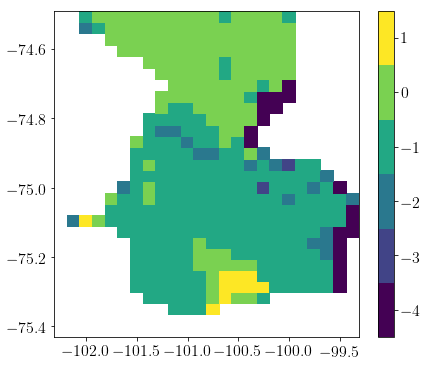

In [22]:
gammat = read_grdchk_from_stdout('/workspace/results/pig/shicoeff-sensitivities/istar-ts-1mo-grdchk-shicoefft/STDOUT.0000')
gammat_accuracy = calc_log_accuracy(ds,gammat)
grdchk_plotter(ds,gammat_accuracy)
test = open_mdsdataset(data_dir='/workspace/ase-adjoint/pig/generic/run_ad_08',
                       grid_dir=grid_dir,
                       iters=0,
                       ignore_unknown_vars=True
                      )

## A look at high resolution sensitivities

In [22]:
grid_32 = open_mdsdataset(data_dir='/workspace/results/pig/time-mean-obj-32/1mo',
                          grid_dir='/workspace/grids/pig_32',
                          iters=0
                         )
#diag_plot(grid_32.XC,grid_32.YC,grid_32.adxx_depth,grid_32.adxx_etan)

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/time-mean-obj-32/1mo. Using default version.
  "in %s. Using default version." % data_dir)


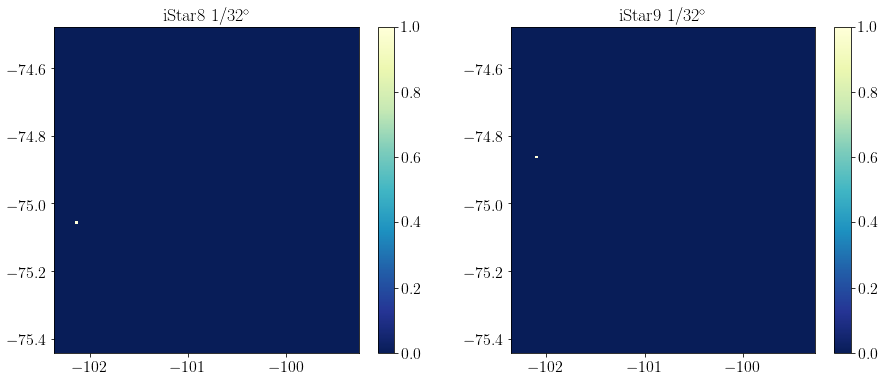

istar_masks_32/iStar8_3d_mskC.meta/data files written ...
istar_masks_32/iStar8_3d_mskC binary file written ...
istar_masks_32/iStar8_3d_mskT.meta/data files written ...
istar_masks_32/iStar8_3d_mskT binary file written ...
istar_masks_32/iStar9_3d_mskC.meta/data files written ...
istar_masks_32/iStar9_3d_mskC binary file written ...
istar_masks_32/iStar9_3d_mskT.meta/data files written ...
istar_masks_32/iStar9_3d_mskT binary file written ...
istar_masks_32/wt_ones.meta/data files written ...
istar_masks_32/wt_ones binary file written ...


In [23]:
# Ok cool it works, make iStar masks...
iStar8_32 = mm.genMooringMask(grid=grid_32,lat=lat8,lon=lon8,depth=mooring_depth,mask_name='iStar8')
iStar9_32 = mm.genMooringMask(grid=grid_32,lat=lat9,lon=lon9,depth=mooring_depth,mask_name='iStar9')
wt_ones = np.where(iStar8_32==iStar8_32,1,0)
temporal_mask = np.array((0,1,0,0,0))
temporal_mask_string = 'np.array((0,1,0,0,0))'

diag_plot(grid_32.XC,grid_32.YC,
          fld1=iStar8_32.sel(Z=mooring_depth[0],method='nearest'),
          title1='iStar8 1/32$^\circ$',
          fld2=iStar9_32.sel(Z=mooring_depth[0],method='nearest'),
          title2='iStar9 1/32$^\circ$'
         )

msk_dir = 'istar_masks_32'
if not os.path.exists(msk_dir):
    os.mkdir(msk_dir)

mm.writeMaskFile(iStar8_32.values,('%s/iStar8_3d_mskC' % msk_dir),
                comments=iStar8_32.attrs['description'])
mm.writeMaskFile(temporal_mask,('%s/iStar8_3d_mskT' % msk_dir),
                comments=temporal_mask_string)

mm.writeMaskFile(iStar9_32.values,('%s/iStar9_3d_mskC' % msk_dir),
                comments=iStar9_32.attrs['description'])
mm.writeMaskFile(temporal_mask,('%s/iStar9_3d_mskT' % msk_dir),
                comments=temporal_mask_string)

mm.writeMaskFile(wt_ones,('%s/wt_ones' % msk_dir),
                comments='ones at every grid cell')

In [24]:
ds_32 = open_mdsdataset(data_dir=('%s/istar-ts-3day_32' % shi_optim_dir),
                        grid_dir='/workspace/grids/pig_32',
                        iters=0
                       )
ds_32_diags = open_mdsdataset(data_dir=('%s/istar-ts-3day_32/diags' % shi_optim_dir),
                        grid_dir='/workspace/grids/pig_32',
                       )

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/istar-ts-3day_32. Using default version.
  "in %s. Using default version." % data_dir)
/workspace/xmitgcm/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/workspace/xmitgcm/xmitgcm/mds_store.py:269: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [25]:
xc32=grid_32.XC
yc32=grid_32.YC
xg32=grid_32.XG
yg32=grid_32.YG

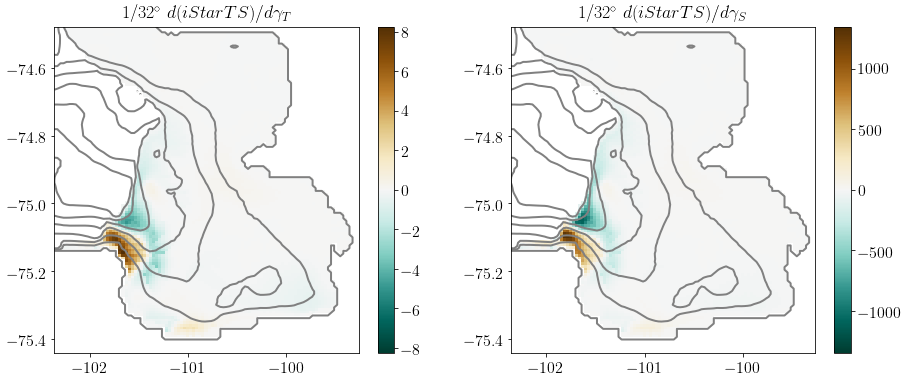

In [26]:
maskI_32=grid_32.maskCtrlI.isel(Z=0)
diag_plot(xc32,yc32,
          ds_32.adxx_shicoefft,ds_32.adxx_shicoeffs,
          title1='1/32$^\circ$ $d (iStar TS) /d\gamma_T$',
          title2='1/32$^\circ$ $d (iStar TS) /d\gamma_S$',
          depth=grid_32.Depth,mask1=maskI_32,mask2=maskI_32
         )

In [27]:
#nt = -1
#
#diag_plot(grid_32.XC,grid_32.YC,
#          ds_32_diags.ETAN.isel(time=nt),
#          ds_32_diags.MXLDEPTH.isel(time=nt),
#          title1='$\eta$ \n t=%d$\delta t$' % nt,
#          title2='MXLD \n t=%d$\delta t$' % nt,
#          depth=grid_32.Depth,
#          mask1=grid_32.maskInC,mask2=grid_32.maskInC
#         )
#diag_plot(grid_32.XC,grid_32.YC,
#          ds_32_diags.SHIhtFlx.isel(time=nt),
#          ds_32_diags.SHIfwFlx.isel(time=nt),
#          title1='SHI Heat Flux \n t=%d$\delta t$' % nt,
#          title2='SHI FW Flux \n t=%d$\delta t$' % nt,
#          depth=grid_32.Depth,
#          mask1=maskI_32,mask2=maskI_32
#         )

Wow, $\eta$ looks weird. Could this be just due to the shape of the cavity?


In [28]:
#diag_plot(xc32,yc32,
#          ds_32.rLowC,ds_32.rSurfC,
#          title1='rLowC',title2='rSurfC',
#         )
#diag_plot(xc32,yc32,
#          ds_32.rLowS,ds_32.rSurfS,
#          title1='rLowS',title2='rSurfS',
#         )
#diag_plot(xc32,yc32,
#          ds_32.rLowW,ds_32.rSurfW,
#          title1='rLowW',title2='rSurfW',
#         )

### For comparison lets try 1 month sensitivity

In [29]:
temporal_mask = np.array((1,0,0,0,0))
mm.writeMaskFile(mask_array=temporal_mask,filename=('%s/iStar8_3d_mskT' % msk_dir),comments="np.array((1,0,0,0,0))")
mm.writeMaskFile(mask_array=temporal_mask,filename=('%s/iStar9_3d_mskT' % msk_dir),comments="np.array((1,0,0,0,0))")

istar_masks_32/iStar8_3d_mskT.meta/data files written ...
istar_masks_32/iStar8_3d_mskT binary file written ...
istar_masks_32/iStar9_3d_mskT.meta/data files written ...
istar_masks_32/iStar9_3d_mskT binary file written ...


In [30]:
ds_32_1mo = open_mdsdataset(data_dir= ('%s/istar-ts-1mo_32' % shi_optim_dir),
                            grid_dir= '/workspace/grids/pig_32',
                            iters=0,
                            ignore_unknown_vars=True
                           )
ds_32_1mo_diags = open_mdsdataset(data_dir= ('%s/istar-ts-1mo_32/diags' % shi_optim_dir),
                            grid_dir= '/workspace/grids/pig_32'
                           )

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-sensitivities/istar-ts-1mo_32. Using default version.
  "in %s. Using default version." % data_dir)


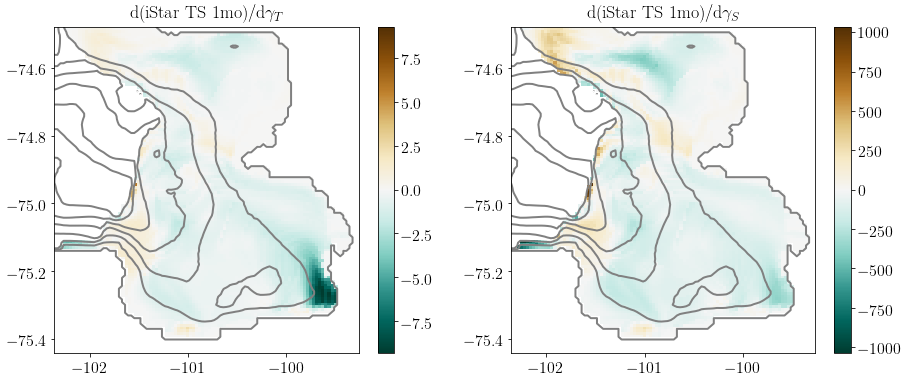

In [31]:
diag_plot(xc32,yc32,ds_32_1mo.adxx_shicoefft,ds_32_1mo.adxx_shicoeffs,
          title1='d(iStar TS 1mo)/d$\gamma_T$',
          title2='d(iStar TS 1mo)/d$\gamma_S$',
          depth=grid_32.Depth,
          mask1=maskI_32,mask2=maskI_32
         )

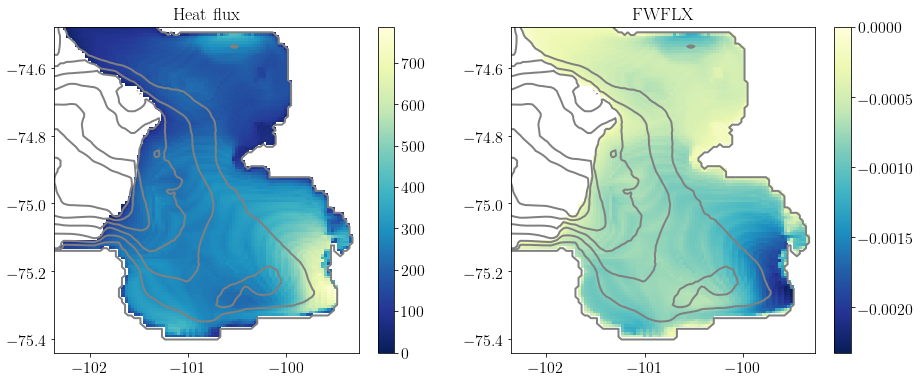

In [32]:
diag_plot(xc32,yc32,ds_32_1mo_diags.SHIhtFlx,ds_32_1mo_diags.SHIfwFlx,
          title1='Heat flux ',
          title2='FWFLX',
          depth=grid_32.Depth,
          mask1=maskI_32,mask2=maskI_32
         )

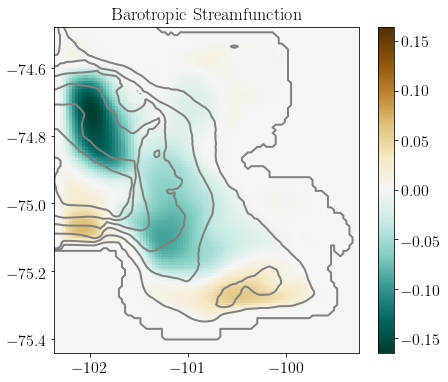

In [36]:
baro_stf = pt.calc_vertical_avg(ds_32_1mo_diags.PsiVEL,msk=ds_32_1mo.maskCtrlC)
baro_stf = baro_stf * 10**-6
diag_plot(xc32,yc32,baro_stf,title1='Barotropic Streamfunction',depth=ds_32_1mo.Depth)

In [1]:
print(12466/3600)

3.4627777777777777


In [3]:
print(ds)

<xarray.Dataset>
Dimensions:    (XC: 25, XG: 25, YC: 30, YG: 30, Z: 50, Zl: 50, Zp1: 51, Zu: 50, time: 11)
Coordinates:
  * XC         (XC) >f4 -102.3125 -102.1875 -102.0625 ... -99.4375 -99.3125
  * YC         (YC) >f4 -75.42998 -75.3985 -75.36696 ... -74.52348 -74.49012
  * XG         (XG) >f4 -102.375 -102.25 -102.125 ... -99.625 -99.5 -99.375
  * YG         (YG) >f4 -75.4457 -75.41425 -75.382744 ... -74.54014 -74.50682
  * Z          (Z) >f4 -10.0 -30.0 -50.0 -70.0 ... -930.0 -950.0 -970.0 -990.0
  * Zp1        (Zp1) >f4 0.0 -20.0 -40.0 -60.0 ... -940.0 -960.0 -980.0 -1000.0
  * Zu         (Zu) >f4 -20.0 -40.0 -60.0 -80.0 ... -940.0 -960.0 -980.0 -1000.0
  * Zl         (Zl) >f4 0.0 -20.0 -40.0 -60.0 ... -920.0 -940.0 -960.0 -980.0
    rA         (YC, XC) >f4 dask.array<shape=(30, 25), chunksize=(30, 25)>
    dxG        (YG, XC) >f4 dask.array<shape=(30, 25), chunksize=(30, 25)>
    dyG        (YC, XG) >f4 dask.array<shape=(30, 25), chunksize=(30, 25)>
    Depth      (YC, XC) >f4 da